In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import kmapper as km
import sklearn as sk
import networkx as nx
from matplotlib.ticker import NullFormatter 
from prettytable import PrettyTable
from IPython.core.display import display, HTML
from matplotlib_venn import venn3_unweighted
from sklearn.decomposition import PCA, KernelPCA
#You should comment the two lines bellow.
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_maf(maf_file_name):
    maf_fields = ["Hugo_Symbol", "Chromosome", "Start_Position", "End_Position", "Reference_Allele", "Tumor_Seq_Allele2", "Variant_Classification", "Variant_Type", "Tumor_Sample_Barcode"]
    maf = pd.read_csv(maf_file_name, sep="\t", usecols=maf_fields,comment="#")
    return maf

def write_maf(maf, output_file_name):
    maf.to_csv(output_file_name, sep='\t')
    
def get_mutations_per_gene(maf):
    mutations_per_gene = {}
    genes = set(maf["Hugo_Symbol"])
    for gene in genes:
        maf_one_gene = maf[maf.Hugo_Symbol.isin([gene])]
        mutations_per_gene[gene] = len(maf_one_gene)
    return mutations_per_gene

def get_mutations_per_patient(maf):
    mutations_per_patient = {}
    patients = set(maf["Tumor_Sample_Barcode"])
    for patient in patients:
        maf_one_gene = maf[maf.Tumor_Sample_Barcode.isin([patient])]
        mutations_per_patient[patient] = len(maf_one_gene)
    return mutations_per_patient

def get_mutated_genes_per_patient(maf):
    bmm = pd.crosstab(maf.Tumor_Sample_Barcode, maf.Hugo_Symbol).clip(upper=1)
    genes = list(bmm)
    mutated_genes_per_patient = {}
    for gene in genes:
        mutated_genes_per_patient[gene] = sum(bmm[gene].tolist())
    return mutated_genes_per_patient

def remove_hipermutated_patients(maf, mutations_per_patient):
    mutations_per_patient_count = list(mutations_per_patient.values())
    q1 = np.quantile(mutations_per_patient_count, .25)
    q2 = np.quantile(mutations_per_patient_count, .50)
    q3 = np.quantile(mutations_per_patient_count, .75)
    iqr = q3 - q1
    threshold_hm = q3 + 4.5*iqr
    mutations_per_patient_filtered = dict(filter(lambda elem: elem[1] <= threshold_hm, mutations_per_patient.items()))
    maf = maf[maf.Tumor_Sample_Barcode.isin(list(mutations_per_patient_filtered))]
    return maf

def get_indicators_from_maf(maf):
    mutations = maf["Hugo_Symbol"]
    genes = set(maf["Hugo_Symbol"])
    patients = set(maf["Tumor_Sample_Barcode"])
    mutations_count = len(mutations)
    genes_count = len(genes)
    patients_count = len(patients)
    return mutations_count, genes_count, patients_count

def get_graph_mutation_per_patient(maf, mutations_per_patient):
    mutations_per_patient_count = list(mutations_per_patient.values())
    mutations_per_patient_count = sorted(mutations_per_patient_count, reverse=True)
    mutations_count, genes_count, patients_count = get_indicators_from_maf(maf)
    plt.figure(figsize=(8, 6))
    x_axis = list(range(0, len(mutations_per_patient_count)))
    #plt.plot(x_axis, mutations_per_patient_count, marker='o')
    plt.bar(x_axis, mutations_per_patient_count, width=1.0, facecolor='black', edgecolor='black')
    plt.title('Mutations per patient')
    plt.xlabel('Patient')
    plt.ylabel('Number of mutations')
    plt.xticks([])
    
    row_labels=["# Mutations", "# Mutated Genes", "# Mutated patients"]
    table_vals=[[mutations_count],[genes_count],[patients_count]]
    table = plt.table(cellText=table_vals,
                  rowLabels=row_labels,
                  colWidths = [0.1]*3,
                  loc='upper right')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    plt.show()
    
def preprocess(maf_file_name, output_file_name):
    maf = read_maf(maf_file_name)
    mutations_per_patient = get_mutations_per_patient(maf)
    
    maf = remove_hipermutated_patients(maf, mutations_per_patient)
    mutations_per_patient = get_mutations_per_patient(maf)
    write_maf(maf, output_file_name)

# Removing hypermutated samples

In [3]:
ids = ["BRCA1", "BRCA2", "BRCA3", "LUAD1", "LUAD2", "LUAD3", "PRAD1", "PRAD2", "PRAD3"]
for i in ids:
    maf_file_name = "./CancerData/" + i + "_data_mutations_extended.txt"
    output_file_name = "./CancerData/" + i + ".maf"
    preprocess(maf_file_name, output_file_name)
    print(i, "finished")

BRCA1 finished
BRCA2 finished
BRCA3 finished
LUAD1 finished
LUAD2 finished
LUAD3 finished
PRAD1 finished
PRAD2 finished
PRAD3 finished


# Indicators

In [4]:
#<tr>=line, <td>=cell
htmlTable='<table><tr><td>Cancer</td><td># Mutations</td><td># Mutated Genes</td><td># Mutated patients</td></tr>'

ids = ["BRCA1", "BRCA2", "BRCA3", "LUAD1", "LUAD2", "LUAD3", "PRAD1", "PRAD2", "PRAD3"]
for i in ids:
    original_maf_file_name = "./CancerData/" + i + "_data_mutations_extended.txt"
    preproc_maf_file_name = "./CancerData/" + i + ".maf"
    original_maf = read_maf(original_maf_file_name)
    preproc_maf = read_maf(preproc_maf_file_name)    
    mutations_count, genes_count, patients_count = get_indicators_from_maf(original_maf)    
    htmlTable+="<tr> <td>Original" + str(i) +"</td><td>"+str(mutations_count)+"</td><td>"+str(genes_count)+"</td><td>"+str(patients_count) +"</td></tr>"
    mutations_count, genes_count, patients_count = get_indicators_from_maf(preproc_maf)
    htmlTable+="<tr> <td>Preprocessed" + str(i) +"</td><td>"+str(mutations_count)+"</td><td>"+str(genes_count)+"</td><td>"+str(patients_count) +"</td></tr>"
htmlTable+="</table>"
display(HTML(htmlTable))

Cancer,# Mutations,# Mutated Genes,# Mutated patients
OriginalBRCA1,33990,13415,507
PreprocessedBRCA1,32627,13169,503
OriginalBRCA2,69968,16178,817
PreprocessedBRCA2,48085,14616,795
OriginalBRCA3,130495,18794,1009
PreprocessedBRCA3,83258,17588,978
OriginalLUAD1,65767,14770,183
PreprocessedLUAD1,55316,14012,179
OriginalLUAD2,72566,15132,230
PreprocessedLUAD2,69176,14977,228


<h1 style='text-align:center'>Graphs</h1>

<h2>Hypermutated</h2>

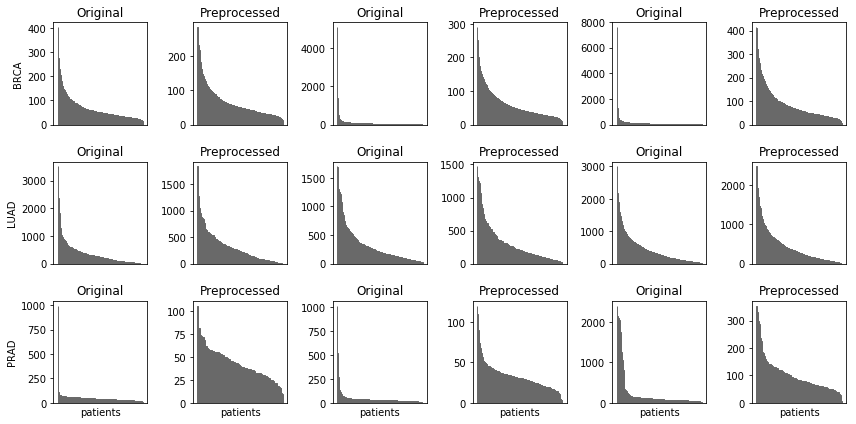

In [5]:
data = []
ids = ["BRCA1", "BRCA2", "BRCA3", "LUAD1", "LUAD2", "LUAD3", "PRAD1", "PRAD2", "PRAD3"]
studysName=["BRCA","LUAD","PRAD"]

for i in ids:
    original_maf_file_name = "./CancerData/" + i + "_data_mutations_extended.txt"
    preproc_maf_file_name = "./CancerData/" + i + ".maf"
    original_maf = read_maf(original_maf_file_name)
    preproc_maf = read_maf(preproc_maf_file_name)

    mutations_per_patient = get_mutations_per_patient(original_maf)
    data.append(mutations_per_patient)
    mutations_per_patient = get_mutations_per_patient(preproc_maf)
    data.append(mutations_per_patient)

num_cancer = 3
num_graphs = num_cancer * 2

fig, a =  plt.subplots(num_cancer, num_graphs, figsize=(12, 6))
x = 0
for i in range(num_cancer):
    for j in range(num_graphs):
        mutations_per_patient = data[x]
        x = x + 1
        mutations_per_patient_count = list(mutations_per_patient.values())
        mutations_per_patient_count = sorted(mutations_per_patient_count, reverse=True)
        x_axis = list(range(0, len(mutations_per_patient_count)))
        a[i][j].bar(x_axis, mutations_per_patient_count, width=1.0, facecolor='dimgray', edgecolor='dimgray')
        a[i][j].set_xticks([])
                
for i in range(num_graphs):
    a[num_cancer - 1][i].set_xlabel("patients")
    
lineCont=0    
for study in studysName:
    a[lineCont][0].set_ylabel(study)
    lineCont+=1
    
    
#Add the 'Original' and 'Preprocessed' titles
lineAux=0
colAux=0
for i in ids:    
    a[lineAux][colAux].set_title("Original")
    a[lineAux][colAux+1].set_title("Preprocessed")
 
    colAux+=2
    if(colAux>5):
        colAux=0
        lineAux+=1

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())

# Adjust the subplot layout
fig.tight_layout(h_pad=1.5, w_pad=1)
#plt.savefig('withAndWithoutHypermutated.png', format='png', dpi=500)
plt.show()

<h2>Variant Classification</h2>

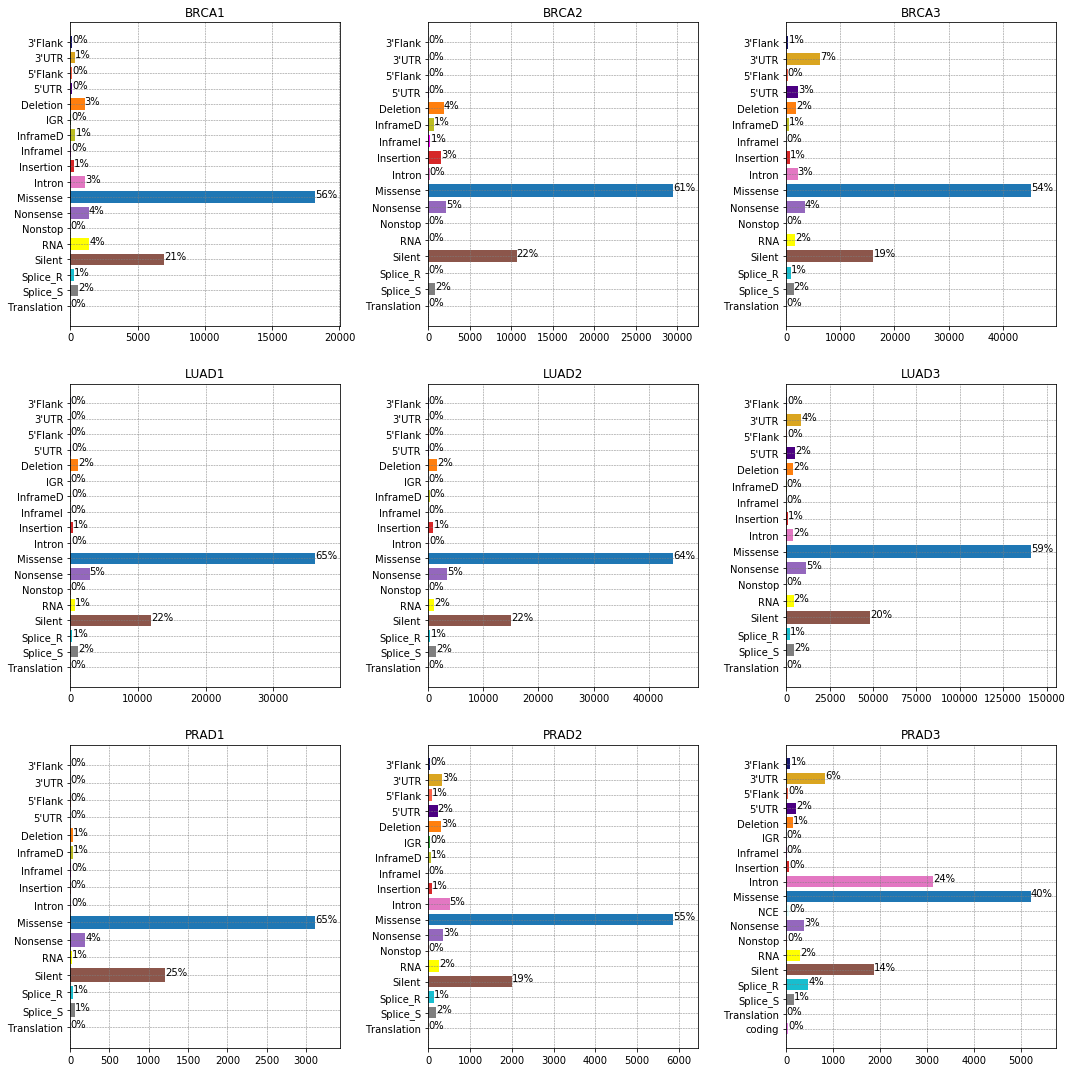

In [6]:
ids = ["BRCA1", "BRCA2", "BRCA3", "LUAD1", "LUAD2", "LUAD3", "PRAD1", "PRAD2", "PRAD3"]

fig, ax = plt.subplots(3,3,figsize=(15, 15))
plotRow=0
plotCol=0
for i in ids:
    preproc_maf_file_name = "./CancerData/" + i + ".maf"
    preproc_maf = read_maf(preproc_maf_file_name)
    numberOfMutations=len(list(preproc_maf['Hugo_Symbol']))
    #Variant types and their quantities 
    variantsType = set(preproc_maf["Variant_Classification"])    
    cont=0
    variantQuantityDic={}
    for v in variantsType:        
        amount=preproc_maf[preproc_maf["Variant_Classification"]==v].shape[0]
        #Adjust the variant name
        if(v=='Missense_Mutation'):
            v='Missense'
        elif(v=='Splice_Region'):
            v='Splice_R'
        elif(v=='Nonsense_Mutation'):
            v='Nonsense'
        elif(v=='Splice_Site'):
            v='Splice_S'
        elif(v=='Frame_Shift_Del'):
            v='Deletion'
        elif(v=='Frame_Shift_Ins'):
            v='Insertion'
        elif(v=='non-coding-exon'):
            v='NCE'
        elif(v=='Nonstop_Mutation'):
            v='Nonstop'
        elif(v=='Translation_Start_Site'):
            v='Translation'
        elif(v=='In_Frame_Ins'):
            v='InframeI'
        elif(v=='In_Frame_Del'):
            v='InframeD'            
        variantQuantityDic[v]=amount
        cont+=amount
    
    
    #===USE THIS IF YOU WANT THE GRAPH SORTED BY THE CLASSIFICATION NAME
    variantQuantity=[]
    for elem in sorted(variantQuantityDic.items(), reverse=True):
        variantQuantity.append(elem)
    variantQuantity
    
    variantsName=[]
    variantsQtty=[]
    variantsQttyOrdered=[]

    for v in variantQuantity:
        variantsName.append(v[0])
        variantsQtty.append(v[1])
        variantsQttyOrdered.append(v[1])

    y_pos = np.arange(len(variantsName))
    
    variantsNameSorted=[]
    for indice in y_pos:
        variantsNameSorted.append(variantsName[indice])
        
    colorList=[]
    #Keep add the colors in the same order that is used in the top10 graph
    for v in variantsNameSorted:
        if(v=='Missense'):
            colorList.append('tab:blue')
        elif(v=='Splice_R'):
            colorList.append('tab:cyan')
        elif(v=='Nonsense'):
            colorList.append('tab:purple')
        elif(v=='Splice_S'):
            colorList.append('tab:gray')
        elif(v=='Deletion'):
            colorList.append('tab:orange')
        elif(v=='Insertion'):
            colorList.append('tab:red')
        elif(v=='NCE'):
            colorList.append('lightcyan')
        elif(v=='Nonstop'):
            colorList.append('salmon')
        elif(v=='Translation'):
            colorList.append('wheat')
        elif(v=='InframeI'):
            colorList.append('fuchsia')
        elif(v=='InframeD'):
            colorList.append('tab:olive')
        elif(v=='IGR'):
            colorList.append('tab:green') 
        elif(v=='Silent'):
            colorList.append('tab:brown')
        elif(v=='Intron'):
            colorList.append('tab:pink')
        elif(v=='3\'Flank'):
            colorList.append('midnightblue')
        elif(v=='5\'Flank'):
            colorList.append('tomato')
        elif(v=='RNA'):
            colorList.append('yellow')
        elif(v=='3\'UTR'):
            colorList.append('goldenrod')
        elif(v=='5\'UTR'):
            colorList.append('indigo')
        elif(v=='coding'):
            colorList.append('violet')

    # Select the actual subplot
    plt.sca(ax[plotRow,plotCol])
    
    # Create horizontal bars
    ax[plotRow,plotCol].barh(y_pos, variantsQtty, height=0.75, color=colorList)
    ax[plotRow,plotCol].set_title(i)
    # Create names on the y-axis
    plt.yticks(y_pos, variantsNameSorted)

    #Add the % in the end
    for x, v in enumerate(variantsQttyOrdered):
        ax[plotRow,plotCol].text(v, x, str(round(v/numberOfMutations*100))+'%', color='black')

    #Increase the X axis to fit %
    xmin, xmax = plt.xlim()
    plt.xlim(xmin, xmax+xmax*0.05)
    
    #Set the number of ticks
    plt.locator_params(axis='x', nbins=7)

    #Plot grid
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    #Walk in the subplots
    plotCol+=1
    if(plotCol==3):
        plotCol=0
        plotRow+=1    
    
    plt.tight_layout(h_pad=2.5, w_pad=1)
    
# Show graphic
#plt.savefig('variant_classification.png', format='png', dpi=250,bbox_inches='tight')
plt.show()   
    

<h2>Variant Type</h2>

{'DNP': 4, 'SNP': 30235, 'DEL': 1822, 'INS': 566}
{'DNP': 169, 'SNP': 43274, 'DEL': 2763, 'INS': 1879}
{'ONP': 3, 'SNP': 79181, 'DEL': 3084, 'INS': 990}
{'TNP': 7, 'DNP': 919, 'INS': 402, 'DEL': 1386, 'SNP': 52602}
{'TNP': 8, 'DNP': 1102, 'INS': 1060, 'SNP': 65068, 'DEL': 1938}
{'TNP': 7, 'ONP': 7, 'INS': 1464, 'SNP': 230704, 'DEL': 5205}
{'DNP': 13, 'SNP': 4647, 'DEL': 83, 'INS': 24}
{'INS': 193, 'SNP': 9740, 'DEL': 613}
{'INS': 122, 'DEL': 262, 'SNP': 12685}


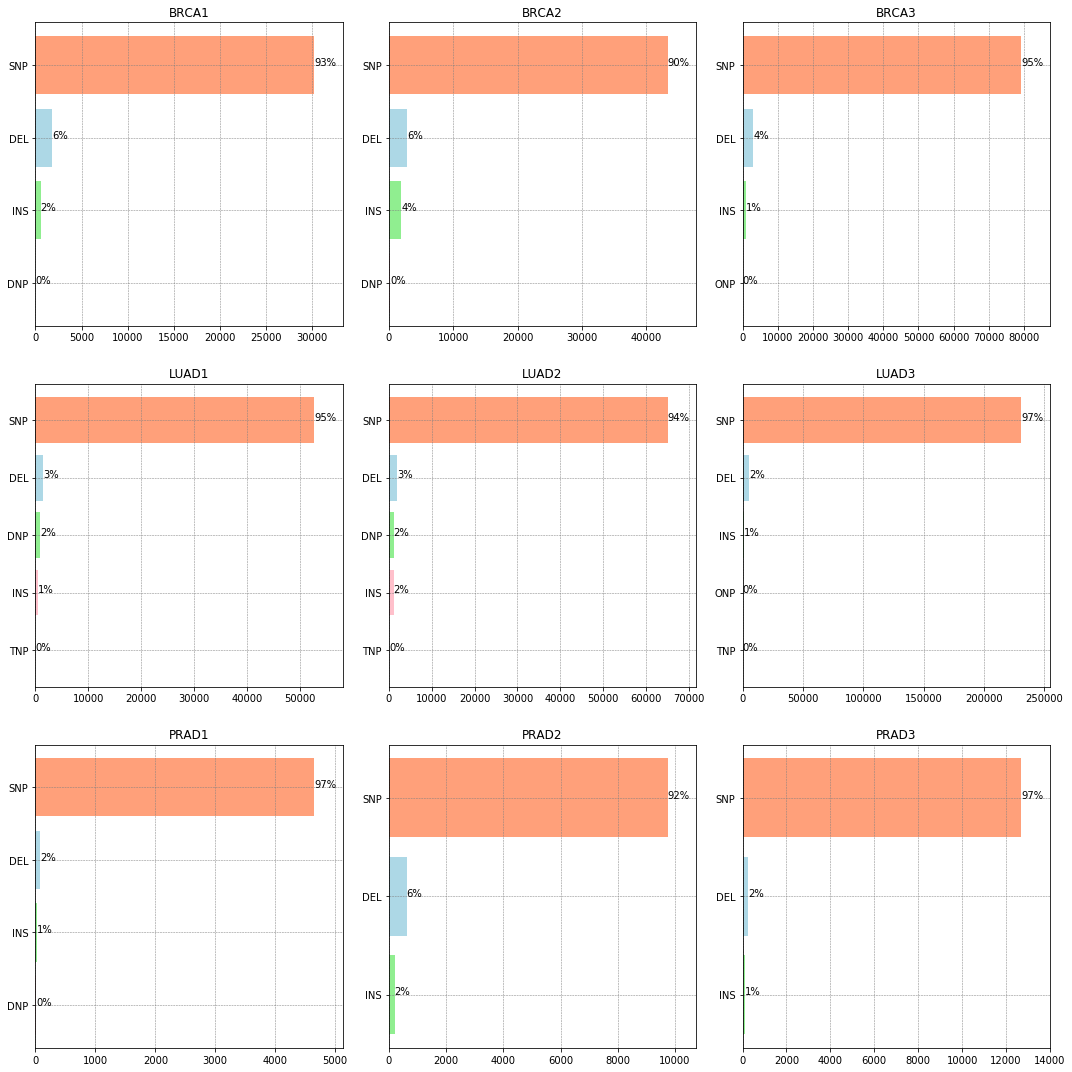

In [7]:
ids = ["BRCA1", "BRCA2", "BRCA3", "LUAD1", "LUAD2", "LUAD3", "PRAD1", "PRAD2", "PRAD3"]

fig, ax = plt.subplots(3,3,figsize=(15, 15))
plotRow=0
plotCol=0
for i in ids:
    preproc_maf_file_name = "./CancerData/" + i + ".maf"
    preproc_maf = read_maf(preproc_maf_file_name)
    numberOfMutations=len(list(preproc_maf['Hugo_Symbol']))
    #Variant types and their quantities 
    variantsType = set(preproc_maf["Variant_Type"])    
    cont=0
    variantQuantity={}
    for v in variantsType:        
        amount=preproc_maf[preproc_maf["Variant_Type"]==v].shape[0]
        variantQuantity[v]=amount
        cont+=amount
    print(variantQuantity)

    #Order the dic into a list
    variantQuantity=sorted(variantQuantity.items(), key=lambda x: x[1])

    variantsName=[]
    variantsQtty=[]
    variantsQttyOrdered=[]

    for v in variantQuantity:
        variantsName.append(v[0])
        variantsQtty.append(v[1])
        variantsQttyOrdered.append(v[1])


    variantsQtty=sorted(variantsQtty,reverse=True)
    y_pos = np.arange(len(variantsName))
    y_pos = sorted(y_pos,reverse=True)
    
    variantsNameSorted=[]
    for indice in y_pos:
        variantsNameSorted.append(variantsName[indice])
    
    # Select the actual subplot
    plt.sca(ax[plotRow,plotCol])
    
    # Create horizontal bars
    ax[plotRow,plotCol].barh(y_pos, variantsQtty, color=['lightsalmon','lightblue','lightgreen','pink','red','tan'])
    ax[plotRow,plotCol].set_title(i)
    # Create names on the y-axis
    plt.yticks(y_pos, variantsNameSorted)

    #Add the % at the end
    for x, v in enumerate(variantsQttyOrdered):
        ax[plotRow,plotCol].text(v, x, str(round(v/numberOfMutations*100))+'%', color='black')

    #Increased the X axes, to fit %
    xmin, xmax = plt.xlim()
    plt.xlim(xmin, xmax+xmax*0.05)

    #Plot grid
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    #Walk in the subplots
    plotCol+=1
    if(plotCol==3):
        plotCol=0
        plotRow+=1    
    
    plt.tight_layout(h_pad=2.5, w_pad=1)
    
#plt.savefig('variantType.png', format='png', dpi=1000,bbox_inches='tight')
plt.show()

<h2>TOP 10 Genes</h2>

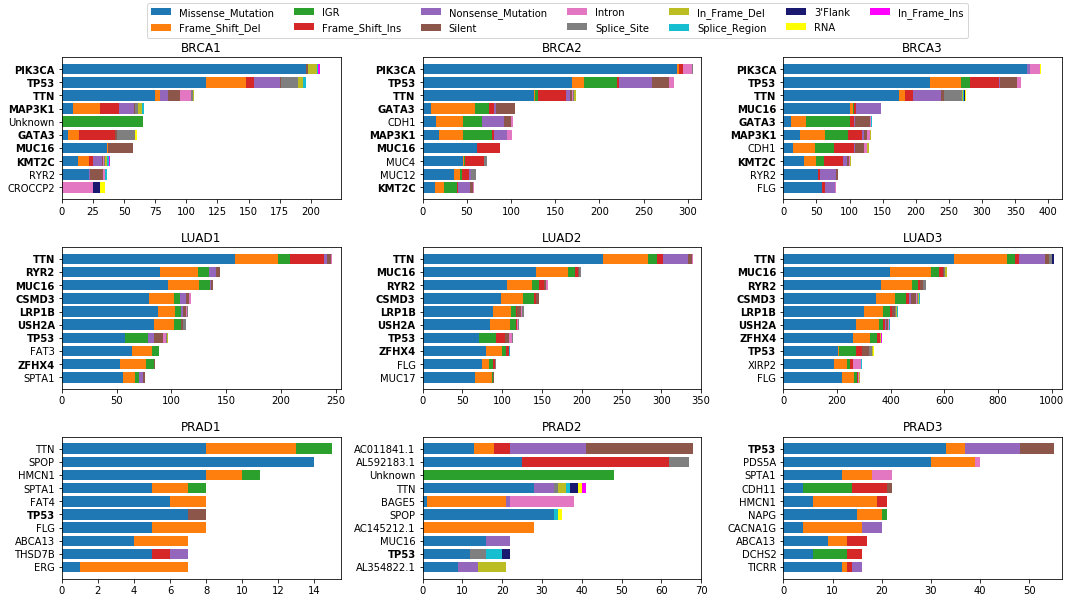

In [8]:
ids = ["BRCA1", "BRCA2", "BRCA3", "LUAD1", "LUAD2", "LUAD3", "PRAD1", "PRAD2", "PRAD3"]

fig, ax = plt.subplots(3,3,figsize=(15, 8))
plotRow=0
plotCol=0
for i in ids:
    preproc_maf_file_name = "./CancerData/" + i + ".maf"
    preproc_maf = read_maf(preproc_maf_file_name)
    numberOfMutations=len(list(preproc_maf['Hugo_Symbol']))    

    top10GenesNames=[]
    variantClassificationType=[]
    #The Ideia here is to create a dataframe with the topgenes as rows, and the variant as columns
    #Foreach gene
    for g in preproc_maf['Hugo_Symbol'].value_counts()[:10].index.tolist():
        top10GenesNames.append(g)
        #foreach variant type of this genes
        for v in preproc_maf[preproc_maf["Hugo_Symbol"]==g]["Variant_Classification"].value_counts().index.tolist():
            variantClassificationType.append(v)

    #remove the repeted variation type
    variantClassificationType=set(variantClassificationType)
    #create a dataframe
    topGenesVariations_df = pd.DataFrame(0, index=top10GenesNames, columns=variantClassificationType)

    ##########

    #fill the dataframe
    for g in preproc_maf['Hugo_Symbol'].value_counts()[:10].index.tolist():
        #foreach variant type of this genes
        for v in preproc_maf[preproc_maf["Hugo_Symbol"]==g]["Variant_Classification"].value_counts().items():
            topGenesVariations_df[v[0]][g]=v[1]
    topGenesVariations_df=topGenesVariations_df.append(topGenesVariations_df.agg(['sum']))
    topGenesVariations_df=topGenesVariations_df.sort_values(by ='sum', axis=1,ascending=False)

    bars=[]
    for c in topGenesVariations_df.columns:
        bars.append(list(topGenesVariations_df[c][:10]))

    npBars=np.array(bars)

    numOfLines=10
    plotBars=[]
    cont=0
    ind = [9,8,7,6,5,4,3,2,1,0]
    colorList=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','midnightblue','yellow','fuchsia']
    
    # Select the actual subplot
    plt.sca(ax[plotRow,plotCol])
    for index in range(len(bars)):
        if(index==0):        
            plotBars.append(ax[plotRow,plotCol].barh(ind,bars[index],color=colorList[index]))
            sumPrevious=npBars[index]
        else:
            plotBars.append(ax[plotRow,plotCol].barh(ind,bars[index],left=sumPrevious,color=colorList[index]))
            sumPrevious+=npBars[index]
            
    
            
    #The first study has all the variant classifications that is necessary for the graph legend 
    if(plotRow==0 and plotCol==0):
        plotBarsColor=plotBars
        plotVariantType=topGenesVariations_df.columns

    plt.title(i)

    xmin, xmax = plt.xlim()
    plt.xlim(xmin, xmax+xmax*0.03)
    #Add the Y Label
    plt.yticks(ind, top10GenesNames)
    
    #Add the bold label for genes that appers in 3 study       
    #When de plotCol==0, there is a new study, so the intersectedGene list é create/reseted
    if(plotCol==0):
        intersectedGenes=top10GenesNames
    else:
        intersectedGenes=set(intersectedGenes).intersection(top10GenesNames)
    plt.draw()
    
    #We need to get the 3 study intersection, before search e bold the genes
    if(plotCol==2):
        for i in range(10):#There will be always 10 label in the top10
            #for the 3 plots in the current row
            if ax[plotRow,0].get_yticklabels()[i].get_text() in intersectedGenes:
                ax[plotRow,0].get_yticklabels()[i].set_fontweight("bold")
            if ax[plotRow,1].get_yticklabels()[i].get_text() in intersectedGenes:
                ax[plotRow,1].get_yticklabels()[i].set_fontweight("bold")
            if ax[plotRow,2].get_yticklabels()[i].get_text() in intersectedGenes:
                ax[plotRow,2].get_yticklabels()[i].set_fontweight("bold")
    
    
    #Walk in the subplots
    plotCol+=1
    if(plotCol==3):
        plotCol=0
        plotRow+=1   
    plt.tight_layout(h_pad=1.5, w_pad=1)
    
#Select the first subplot. This is necessary for legend placemeallnt
plt.sca(ax[0,0])
fig.legend(plotBarsColor, plotVariantType,loc='upper center', bbox_to_anchor=(0.516, 1.05),ncol=7)
fig.tight_layout(h_pad=1.5, w_pad=1)
#plt.savefig("top_10_genes.png", format='png', dpi=250, bbox_inches='tight')
plt.show() 

# SNV Classes

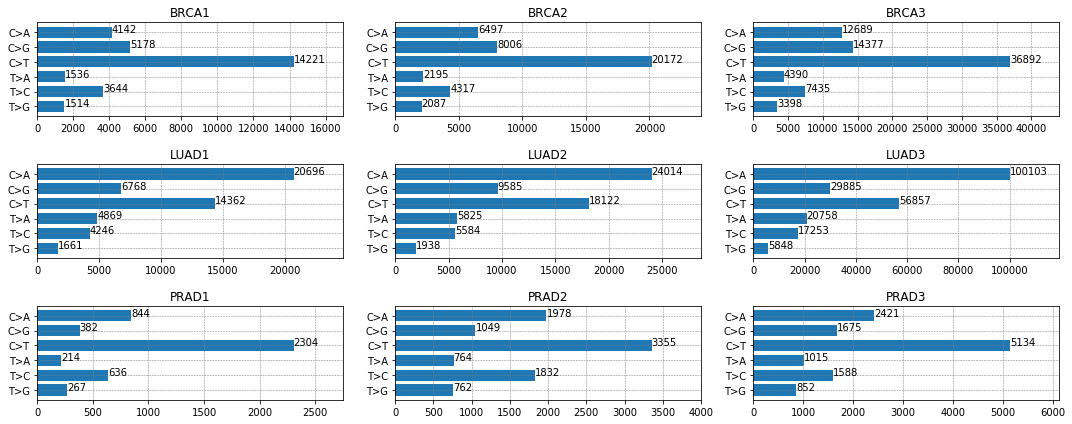

In [9]:
ids = ["BRCA1", "BRCA2", "BRCA3", "LUAD1", "LUAD2", "LUAD3", "PRAD1", "PRAD2", "PRAD3"]

fig, ax = plt.subplots(3,3,figsize=(15, 6))
plotRow=0
plotCol=0
for i in ids:
    preproc_maf_file_name = "./CancerData/" + i + ".maf"
    preproc_maf = read_maf(preproc_maf_file_name)
    
    #There are many types of alleles in MAF (print(reference_Alleles)). Most of them are unique.
    reference_Alleles=set(preproc_maf['Reference_Allele'])
    #Get only the 1 lenght/size allele
    aux_df = preproc_maf[[ x in ('A', 'C', 'G', 'T') for x in preproc_maf['Reference_Allele']]]
    reference_Alleles_Lenght1=set(aux_df['Reference_Allele'])

    #The same thing with the Tumor Seq Allele
    tumor_Seq_Allele2=set(preproc_maf['Tumor_Seq_Allele2'])

    #Get only the 1 lenght/size allele
    aux_df = preproc_maf[[ x in ('A', 'C', 'G', 'T') for x in preproc_maf['Tumor_Seq_Allele2']]]
    tumor_Seq_Allele2_Lenght1=set(aux_df['Tumor_Seq_Allele2'])

    reference_Alleles_Lenght1=sorted(reference_Alleles_Lenght1)
    tumor_Seq_Allele2_Lenght1=sorted(tumor_Seq_Allele2_Lenght1)

    #Combine the two lists
    snvClass={}
    for r in reference_Alleles_Lenght1:
        for t in tumor_Seq_Allele2_Lenght1:
            if(r != t):
                key=str(r)+'>'+str(t)
                snvClass[key]=len(preproc_maf.loc[(preproc_maf['Reference_Allele']==r) & (preproc_maf['Tumor_Seq_Allele2']==t)])

    #Plot only the C>* e T>*
    snvToPlot={}
    for r in ['C','T']:
        for t in ['A', 'C', 'G', 'T']:
            if(r != t):
                key=str(r)+'>'+str(t)
                snvToPlot[key]=snvClass[key]
    #sum the "mirror" SNV
    snvToPlot['C>A']+=snvClass['G>T']
    snvToPlot['C>G']+=snvClass['G>C']
    snvToPlot['C>T']+=snvClass['G>A']
    snvToPlot['T>A']+=snvClass['A>T']
    snvToPlot['T>C']+=snvClass['A>G']
    snvToPlot['T>G']+=snvClass['A>C']
   
    y_pos=np.arange(len(snvToPlot))
    snvValues=list(snvToPlot.values())
    snvKeys=list(snvToPlot.keys())
    snvKeys.reverse()
    snvValues.reverse()

    # Create horizontal bars
    ax[plotRow,plotCol].barh(y_pos, snvValues, height=0.75)
    ax[plotRow,plotCol].set_title(i)
    
    # Select the actual subplot
    plt.sca(ax[plotRow,plotCol])
    # Create names on the y-axis
    plt.yticks(y_pos, snvKeys)

    #Add the % at the end
    for x, v in enumerate(snvValues):
        ax[plotRow,plotCol].text(v, x, v, color='black')

    #Increase the X axis to fit %
    xmin, xmax = plt.xlim()
    plt.xlim(xmin, xmax+xmax*0.135)

    #Plot grid
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    #Walk in the subplots
    plotCol+=1
    if(plotCol==3):
        plotCol=0
        plotRow+=1
    plt.tight_layout(h_pad=1.5, w_pad=1)
    
# Show graphic
#plt.savefig("SNV.png", format='png', dpi=250,bbox_inches='tight')
plt.show()

#  Identification of driver mutations

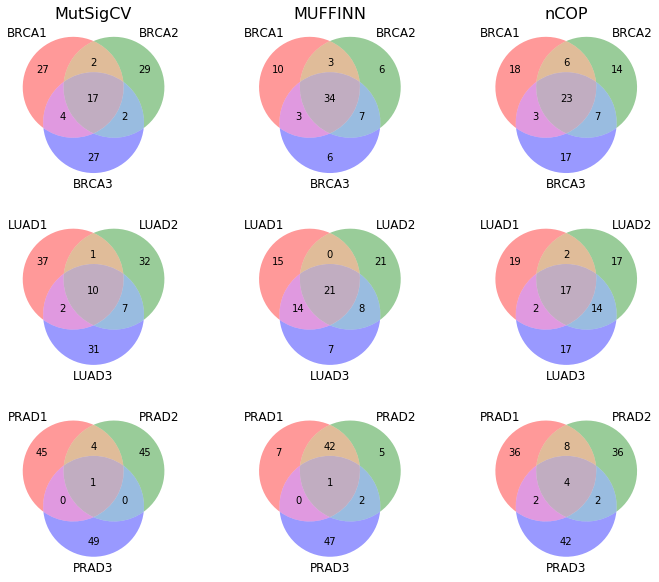

In [10]:
def get_mutsigcv_results(results_file_name, top_N):
    df = pd.read_csv(results_file_name, sep="\t", usecols=["gene"])
    results = list(df["gene"])
    results = results[0:top_N]
    return results

def get_muffinn_results(results_file_name, top_N):
    df = pd.read_csv(results_file_name, sep="\t", usecols=["Gene_Symbol"])
    results = list(df["Gene_Symbol"])
    results = results[0:top_N]
    return results

def get_ncop_results(results_file_name, top_N):
    df = pd.read_csv(results_file_name, usecols=[0], names=["gene"], sep=' ')
    results = list(df["gene"])
    results = results[0:top_N]
    return results

def get_method_results(method, dataset_id):
    results = []
    top_N = 50
    if method == "MutSigCV":
        file_name = "./CompMethodDriverMutationIdentification/MutSigCV_results/" + dataset_id + "_results.sig_genes.txt"
        results = get_mutsigcv_results(file_name, top_N)
    elif method == "MUFFINN":
        file_name = "./CompMethodDriverMutationIdentification/MUFFINN_results/" + "DNmax_" + dataset_id + ".STRINGv10"
        results = get_muffinn_results(file_name, top_N)
    elif method == "nCOP":
        file_name = "./CompMethodDriverMutationIdentification/nCOP_results/" + dataset_id + "_results.txt"
        results = get_ncop_results(file_name, top_N)
    return set(results)

num_methods = 3
num_datasets = 3
methods = ["MutSigCV", "MUFFINN", "nCOP"]
cancer_datasets = [["BRCA1", "BRCA2", "BRCA3"], ["LUAD1", "LUAD2", "LUAD3"], ["PRAD1", "PRAD2", "PRAD3"]]


fig, ax =  plt.subplots(num_datasets, num_methods, figsize=(12, 10))
for i in range(num_datasets):
    for j in range(num_methods):
        set1 = get_method_results(methods[j], cancer_datasets[i][0])
        set2 = get_method_results(methods[j], cancer_datasets[i][1])
        set3 = get_method_results(methods[j], cancer_datasets[i][2])

        venn3_unweighted([set1, set2, set3], set_labels=cancer_datasets[i], ax=ax[i][j])
        if i == 0:
            ax[i][j].set_title(methods[j], fontsize=16)

plt.show()

#  Network Analysis - Mapper

In [11]:
def readDataSetReturnFeatures(dataSetName):
    df = pd.read_csv('mapperData/'+dataSetName+'_genesWithClinicalData_.csv', sep=';', index_col=0)

    feature_names = [c for c in df.columns]

    Z = np.array(df[feature_names].fillna(0))
    X = Z[:,1::].copy()

    return X[:,1::].copy()

def createGraphFromMapper(X_,nameToSave):
    nameToSave='mapperData/'+nameToSave
    mapper = km.KeplerMapper(verbose=0)
    lens = mapper.fit_transform(X_, projection=PCA(n_components=2))

    # Create the simplicial complex
    graph = mapper.map(lens,
                       X_,
                       cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                                       clusterer=sk.cluster.KMeans(n_clusters=5,random_state=30))                                  

    # Visualization
    mapper.visualize(graph,
                     path_html=nameToSave+"-pca2.html",
                     title=nameToSave.upper()+" Cancer Dataset",
                     custom_tooltips=np.arange(len(lens)))
    return graph

def createNetworkXgraph(mapperGraph):
    return km.adapter.to_nx(mapperGraph)

def exportGraph(nxGraph,nameToSave):
    nameToSave='mapperData/'+nameToSave
    nx.write_gml(nxGraph, nameToSave+".gml")
    nx.write_edgelist(nxGraph, nameToSave+".edgeListCSV",data=False,delimiter=';')
    
def printGraphInformation(nx_graph):
    
    largest_cc = nx_graph.subgraph(max(nx.connected_components(nx_graph), key=len)).copy()
    
    numcc = nx.number_connected_components(nx_graph)
    print("number of Conected Components (CoC) "+str(numcc))

    avc = nx.average_clustering(nx_graph)
    print("Average Clustering (CC) "+str(avc))
    
    dga = nx.degree_assortativity_coefficient(nx_graph)
    print("Assortativity Coefficient "+str(dga))
      
    
    d = nx.diameter(largest_cc)
    print("Diameter (d) "+str(d))
    
    avgsp = nx.average_shortest_path_length(largest_cc)
    print("Average Shortest Paths (sp)"+str(avgsp))
    
    #The return is a list used to color the graph.
#     betwc = nx.betweenness_centrality(nx_graph)
#     print("Betweenness Centrality "+str(betwc))

In [12]:
studyList=['brca1','brca2','brca3']
nxGraphsDic={}
mapperGraphsDic={}
for study in studyList:
    X_ = readDataSetReturnFeatures(study)
    
    mapperGraph = createGraphFromMapper(X_,study)
    mapperGraphsDic[study]=mapperGraph
    
    nxGraph = createNetworkXgraph(mapperGraph)    
    nxGraphsDic[study]=nxGraph
    
    exportGraph(nxGraph,study)
    print("\n==="+study+'===\n')
    printGraphInformation(nxGraph)


===brca1===

number of Conected Components (CoC) 59
Average Clustering (CC) 0.5127325056139063
Assortativity Coefficient 0.5016068996958795
Diameter (d) 35
Average Shortest Paths (sp)10.097527296502125

===brca2===

number of Conected Components (CoC) 42
Average Clustering (CC) 0.49439585332736896
Assortativity Coefficient 0.521656601795602
Diameter (d) 31
Average Shortest Paths (sp)9.651008262836907

===brca3===

number of Conected Components (CoC) 37
Average Clustering (CC) 0.5119791963759805
Assortativity Coefficient 0.565643307107422
Diameter (d) 19
Average Shortest Paths (sp)7.777436949434227


In [13]:
####################### GENES INTERSECTION - THE MAPPER GRAPHS LCCs ##############

lccSets=[]
name="Number of genes intersection in: "
for key in nxGraphsDic:
    name+=key+' '
    lcc=nxGraphsDic[key].subgraph(max(nx.connected_components(nxGraphsDic[key]), key=len)).copy()
    nodes = nx.nodes(lcc)
    totalGenesInLCC=[]
    #each node in the graph is one or more genes
    for n in nodes:
        [totalGenesInLCC.append(x) for x in mapperGraphsDic[key]['nodes'][n]]
    print("Size of the "+key+" LCC: "+str(len(lcc)))
    print("Number of genes in the "+key+" LCC: "+str(len(set(totalGenesInLCC))))
    print("\n")
    lccSets.append(set(totalGenesInLCC))

name+='= '
intersection=lccSets[len(lccSets)-1]
for i in range(len(lccSets)-1):
    intersection = intersection & lccSets[i]

print(name+str(len(intersection)))

Size of the brca1 LCC: 875
Number of genes in the brca1 LCC: 12140


Size of the brca2 LCC: 1105
Number of genes in the brca2 LCC: 13737


Size of the brca3 LCC: 1019
Number of genes in the brca3 LCC: 16981


Number of genes intersection in: brca1 brca2 brca3 = 11032


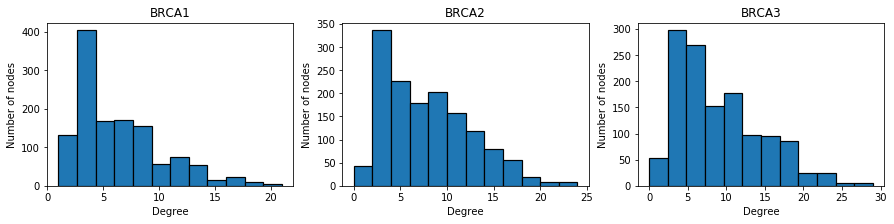

In [14]:
####################### DEGREE DISTRIBUTION  ################

###HISTOGRAM
fig,ax = plt.subplots(1,3,figsize=(15,3))
col=0
for key in nxGraphsDic:
    degrees = [nxGraphsDic[key].degree(n) for n in nxGraphsDic[key].nodes()]

    ax[col].hist(degrees,edgecolor='black', linewidth=1.2,bins=12)
    # Select the actual subplot
    plt.sca(ax[col])
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    #xmin,xmax=plt.xlim()
    #plt.xticks(np.arange(2,int(xmax),2))
    plt.title(key.upper())
    col+=1

#plt.savefig('degreeDistributionHistogram.png', format='png', dpi=200,bbox_inches='tight')
plt.show()